In [30]:
import numpy as np
from numba import cuda
from time import time
import math
import matplotlib.pyplot as plt

In [31]:
# умножение с помощю np, возвращает итоговую матрицу и время работы
def dot_cpu(a, b):
  start = time()
  c = np.dot(a, b)
  return c, time() - start

# функция умножения на gpu
@cuda.jit
def dot_gpu(a, b, c):
    i, j = cuda.grid(2)
    if i < c.shape[0] and j < c.shape[1]:
      tmp = 0
      for k in range(a.shape[1]):
        tmp += a[i, k] * b[k, j]
      c[i, j] = tmp

# функция которая, подготавливает все для запуска на гпу и вызывает функцию
def exec_gpu(a, b, c):
  # количество нитей в блоке
  tread_number_block = 32
  # копируем на гпу все данные
  a_global = cuda.to_device(a)
  b_global = cuda.to_device(b)
  c_global = cuda.device_array((a.shape[0], a.shape[1]))
    
  # создаем сетку
  threadsperblock = (tread_number_block, tread_number_block)
  blockspergrid_x = int(math.ceil(a.shape[0] / threadsperblock[1]))
  blockspergrid_y = int(math.ceil(b.shape[1] / threadsperblock[0]))
  blockspergrid = (blockspergrid_x, blockspergrid_y)

  start = time()
  # вызываем функцию на сетке
  dot_gpu[blockspergrid, threadsperblock](a_global, b_global, c_global)
  gpu_time = time() - start
  c_gpu = c_global.copy_to_host() 
  return c_gpu, gpu_time

**Произведение вычислений и вывод результатов**

In [56]:
def experiment(n):  
  gpu_time = 0
  cpu_time = 0
  a = np.random.randint(0, 10, (n, n)).astype(np.float64)
  b = np.random.randint(0, 10, (n, n)).astype(np.float64)
  c = np.zeros((n, n)).astype(np.float64)
    
  c_gpu, gpu_time = exec_gpu(a, b, c)
  start = time()
  c_cpu, cpu_time = dot_cpu(a, b)

  return cpu_time/gpu_time, cpu_time, gpu_time

# n = [128, 256, 512, 1024, 2048]
n = range(100, 2100, 100)
# n = [100, 128, 200, 256, 300, 400, 500, 512, 600, 700, 800, 900, 1000, 1024, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2048]
a = []
c = []
g = []
for ni in n:
  ai, ci, gi = experiment(ni)
  a.append(ai)
  c.append(ci)
  g.append(gi)

print('|n\t|cpu\t\t|gpu\t\t|a\t\t|')
for i in range(len(n)):
  # print('|',n[i],'\t|',c[i],'\t|',g[i],'\t|')
  print('|{:d}\t|{:f}\t|{:f}\t|{:f}\t|'.format(n[i], c[i], g[i], a[i]))

|n	|cpu		|gpu		|a		|
|100	|0.004259	|0.000442	|9.634304	|
|200	|0.001849	|0.000327	|5.657185	|
|300	|0.001826	|0.000538	|3.391054	|
|400	|0.003521	|0.000506	|6.959001	|
|500	|0.006486	|0.000409	|15.853147	|
|600	|0.011333	|0.000814	|13.927630	|
|700	|0.017124	|0.000449	|38.143919	|
|800	|0.025570	|0.000484	|52.884122	|
|900	|0.036519	|0.000523	|69.814494	|
|1000	|0.050457	|0.000545	|92.659370	|
|1100	|0.066093	|0.000560	|118.114188	|
|1200	|0.082065	|0.000530	|154.768885	|
|1300	|0.103313	|0.000531	|194.403769	|
|1400	|0.130593	|0.000509	|256.436330	|
|1500	|0.159770	|0.000574	|278.406315	|
|1600	|0.195457	|0.000560	|349.150767	|
|1700	|0.230680	|0.000392	|587.814095	|
|1800	|0.277261	|0.000419	|661.501138	|
|1900	|0.320773	|0.000415	|773.673951	|
|2000	|0.367951	|0.000401	|917.538644	|


**График зависимости получаемого ускорения от размерности матриц**

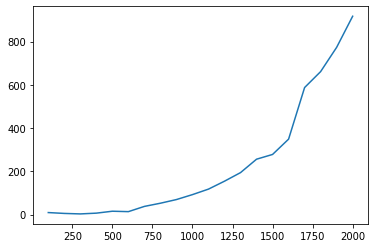

In [57]:
plt.plot(np.array(n), np.array(a))
plt.show()

**Проверка корректности вычисления на GPU**

In [13]:
def check_dot(n):
  a = np.random.randint(0, 10, (n, n)).astype(np.float64)
  b = np.random.randint(0, 10, (n, n)).astype(np.float64)
  c = np.zeros((n, n)).astype(np.float64)

  c_cpu = dot_cpu(a,b)[0]
  c_gpu = exec_gpu(a, b, c)[0]
  if np.array_equal(c_cpu, c_gpu):
    print('Считается корректно')


check_dot(128)

Считается корректно
